In [1]:
import json
import numpy as np
import shutil
import glob
from tqdm import tqdm
import pandas as pd
import unidecode
import os
import subprocess
import  tarfile
import xml.etree.ElementTree as ET
import ast
import zipfile
import datetime

# Le Figaro

## processing the data

In [2]:
os.makedirs('/scratch/students/antoun/Avenir/filtered_avenir', exist_ok=True)

In [3]:
json_files = glob.glob('/scratch/students/antoun/corpus/le_figaro/**/*.json', recursive=True)

# Count the number of files, which represents the number of articles
num_articles = len(json_files)

print("Total number of articles:", num_articles)

Total number of articles: 28503


In [4]:
# Traverse all JSON files
json_count = 0
filter_count = 0
for root, dirs, files in os.walk('/scratch/students/antoun/corpus/le_figaro'):
    for file_name in files:
        if file_name.endswith('.json'):
            with open(os.path.join(root, file_name)) as json_file:
                json_text = json.load(json_file)
                json_count += 1
        
        #check if "avenir" is in file
                if "avenir" in json.dumps(json_text):
            # Copy file in filtered file directoy
                    shutil.copyfile(os.path.join(root, file_name), os.path.join('/scratch/students/antoun/figaro_words/Avenir/filtered_avenir', file_name))
                    filter_count += 1
                
print(f"Found {json_count} JSON files in the directory")
print(filter_count)
        
        

Found 28503 JSON files in the directory
23034


In [5]:
print(f"Found {json_count} JSON files in the directory")
print(f"Found  {filter_count} JSON filtered files according to the word avenir")

Found 28503 JSON files in the directory
Found  23034 JSON filtered files according to the word avenir


In [6]:
if not os.path.exists("/scratch/students/antoun/Avenir/data"):
    os.makedirs("/scratch/students/antoun/Avenir/data")

#Get list of all articles
every_article = glob.glob('/scratch/students/antoun/figaro_words/Avenir/filtered_avenir/*.json')
avenir_articles = pd.DataFrame(columns=["publication_date", "content"])
dates_fr = set()
for article in tqdm(every_article):
    date = article.split("/")[-1][:10] #ask
    dates_fr.add(date)
    with open(article, 'r') as f:
        data = json.load(f)   
        if "avenir" in unidecode.unidecode(str.lower(data["contentAsText"][0])):
            avenir_articles.loc[date] = {"publication_date" : date, "content":data["contentAsText"][0]}
            #length = len(content)
            #avenir_articles.loc[date] = {"publication_date": date, "content": content, "length": length}

            
            
#sort data by publication date
avenir_articles.sort_values(by = ["publication_date"], inplace =True)

#save the data
avenir_articles.to_csv("/scratch/students/antoun/figaro_words/Avenir/avenir_articles_fr.csv")

# Save dates
with open('/scratch/students/antoun/figaro_words/Avenir/data/dates_fr.txt','w') as f:
    f.write(str(dates_fr))
    
#sort the dates
with open('/scratch/students/antoun/figaro_words/Avenir/data/dates_fr.txt', 'w') as f:
# parse dates as datetime objects and sort them
    dates_fr_sorted = sorted([datetime.datetime.strptime(date, '%Y%m%d.m') for date in dates_fr])
    # convert datetime objects back to strings in the desired format and write them to file
    f.write('\n'.join([date.strftime('%Y%m%d.m') for date in dates_fr_sorted]))
    
# calculate average length of articles
#avg_length = avenir_articles["length"].mean()

# print the result
#print("Average article length:", avg_length)

    

100%|██████████████████████████████████████████████████████| 23034/23034 [04:04<00:00, 94.10it/s]


# Counting the raw frequency of "avenir"

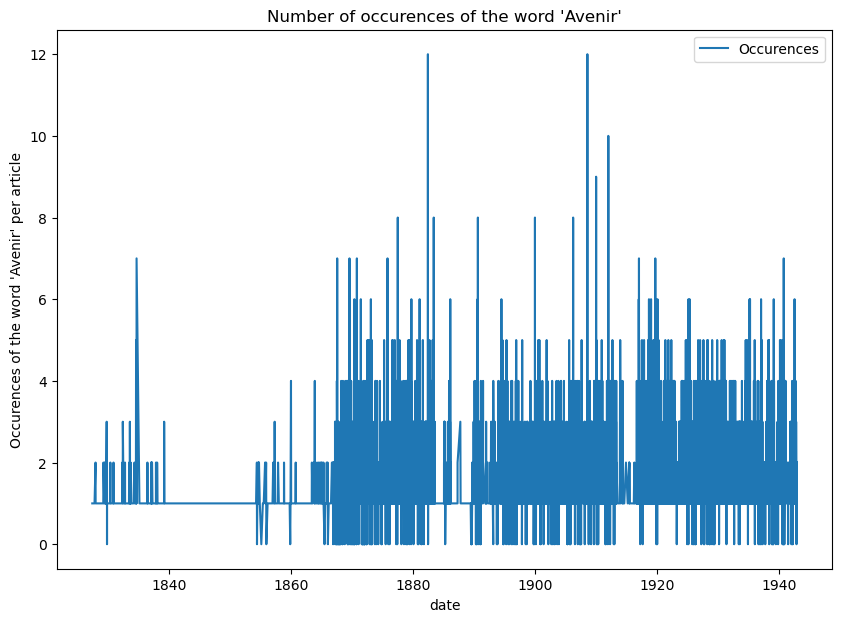

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

df = pd.read_csv("/scratch/students/antoun/figaro_words/Avenir/avenir_articles_fr.csv")
df = df.sort_values(by = "publication_date")

#convert column "piblication_date" from string to date time format
df["publication_date"] = pd.to_datetime(df["publication_date"], format = "%Y%m%d.m").dt.date

#set index to piblication date column
df = df.set_index("publication_date")
x = np.arange(len(df))

#function that counts raw frequency
def count_word_frequency(word, text):
    return text.count(word)

word = "avenir"
df["frequency"] = df["content"].apply(lambda x: count_word_frequency(word, x))



y = df["frequency"]
degree = 10
coeffs = np.polyfit(x, y, degree)
frequencies_polyfit = np.polyval(coeffs, x)

#plot
plt.figure(figsize=(10,7))
plt.plot(df.index, df["frequency"], label = "Occurences")
plt.title("Number of occurences of the word 'Avenir'")
plt.xlabel("date")
plt.ylabel("Occurences of the word 'Avenir' per article")
plt.legend()
plt.show()

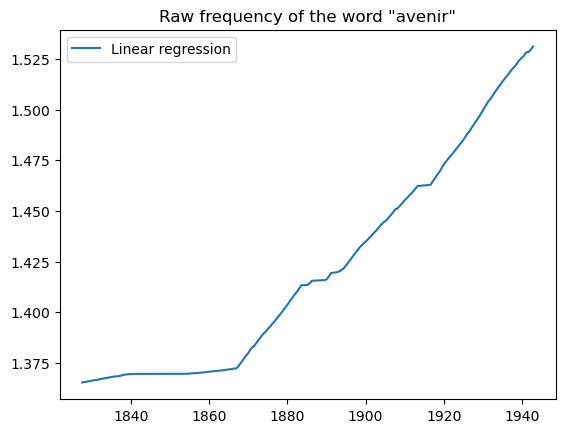

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
x = np.arange(len(df)).reshape(-1, 1)
y = df['frequency'].values.reshape(-1, 1)
model.fit(x, y)

plt.plot(df.index, model.predict(x), label = "Linear regression")
plt.title('Raw frequency of the word "avenir"')
plt.xlabel
plt.legend()
plt.show()

## key word in context of "l'avenir est"

In [3]:
import nltk 
nltk.download('punkt')
from nltk import ngrams
from nltk.text import Text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

[nltk_data] Downloading package punkt to /home/tamantoun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dividing dates into four blocks


In [4]:
# Load the CSV file into a pandas data frame
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("/scratch/students/antoun/figaro_words/Avenir/avenir_articles_fr.csv")

df['publication_date'] = pd.to_datetime(df['publication_date'], format='%Y%m%d.m').dt.date

# Define the date ranges
range0 = (datetime.datetime.strptime('18260101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18401231.m', '%Y%m%d.m').date())

range1 = (datetime.datetime.strptime('18400101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18601231.m', '%Y%m%d.m').date())

range2 = (datetime.datetime.strptime('18600101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('18801231.m', '%Y%m%d.m').date())

range3 = (datetime.datetime.strptime('18800101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19001231.m', '%Y%m%d.m').date())

range4 = (datetime.datetime.strptime('19000101.m', '%Y%m%d.m').date(),
          datetime.datetime.strptime('19201231.m', '%Y%m%d.m').date())

# Open the file and read the dates
with open('/scratch/students/antoun/figaro_words/Avenir/data/dates_fr.txt', 'r') as f:
    dates = f.read().splitlines()

# Convert the dates to date objects
dates = [datetime.datetime.strptime(date, '%Y%m%d.m').date() for date in dates]

block0 =  df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range0[0], range0[1])]
new_value0 = block0["content"].apply(nltk.word_tokenize) 
block0.loc[:, "tokens"] =  new_value0

block1 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range1[0], range1[1])]
new_value1 = block1["content"].apply(nltk.word_tokenize) 
block1.loc[:, "tokens"] =  new_value1

block2 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range2[0], range2[1])]
new_value2 = block2["content"].apply(nltk.word_tokenize) 
block2.loc[:, "tokens"] =  new_value2

block3 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range3[0], range3[1])]
new_value3 = block3["content"].apply(nltk.word_tokenize) 
block3.loc[:, "tokens"] =  new_value3

block4 = df.loc[df["publication_date"].isin(dates) & df["publication_date"].between(range4[0], range4[1])]
new_value4 = block4["content"].apply(nltk.word_tokenize) 
block4.loc[:, "tokens"] =  new_value4

# Print the number of dates in each block
print(f"Block 0 ({range0[0]} - {range0[1]}): {len(block0)} dates")
print(f"Block 1 ({range1[0]} - {range1[1]}): {len(block1)} dates")
print(f"Block 2 ({range2[0]} - {range2[1]}): {len(block2)} dates")
print(f"Block 3 ({range3[0]} - {range3[1]}): {len(block3)} dates")
print(f"Block 4 ({range4[0]} - {range4[1]}): {len(block4)} dates")

Block 0 (1826-01-01 - 1840-12-31): 280 dates
Block 1 (1840-01-01 - 1860-12-31): 97 dates
Block 2 (1860-01-01 - 1880-12-31): 2370 dates
Block 3 (1880-01-01 - 1900-12-31): 2181 dates
Block 4 (1900-01-01 - 1920-12-31): 2669 dates


## 2-grams before and after "l'avenir" in block 1

In [6]:
import string
punctuations = string.punctuation

In [7]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 1
two_grams_block_1_before = []
two_grams_block_1_after = []



for doc in block1["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("l'avenir"):
            if i > 1:
                two_grams_block_1_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_1_after.append((doc[i+1], doc[i+2]))



# Compute the frequency distribution of the tri-grams for block 1
freq_dist_block_1_before = FreqDist(two_grams_block_1_before)
freq_dist_block_1_after = FreqDist(two_grams_block_1_after)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/two-grams-output1.txt", "w") as file:
    # Write the two-grams before "avenir"
    file.write("-------------------------BLOCK_1-----------------------Two-grams before 'avenir':\n")
    for two_gram in two_grams_block_1_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "avenir"
    file.write("-------------------------BLOCK_1-----------------------Two-grams after 'avenir':\n")
    for two_gram in two_grams_block_1_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")


# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 1 (1840-1860): \n")
print(f"2-grams before 'l'avenir': \n")
print(two_grams_block_1_before, "\n")
print(f"2-grams after 'l'avenir': \n")
print(two_grams_block_1_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_1_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_1_after.most_common())

Block 1 (1840-1860): 

2-grams before 'l'avenir': 

[('voici', 'A'), ('fier', 'à'), ('plus', 'à'), ('rêver', 'à'), ('serait', 'à'), ('plus', 'à'), ('parole', 'de'), ('pensait', 'à'), ('espérances', 'de'), ('tout', '—'), ('avisé', 'et'), ('il', 'évoque'), ('tragédiennes', 'de'), ('calembodrgs', 'et'), ('qu', 'à'), ('problèmes', 'de'), ('présent', 'et'), ('passé', 'et'), ('qu', 'à'), ('en', 'garde'), ('surveiller', 'à'), ('qu', 'à'), ("s'imposer", 'a'), ('souvent', 'compromet'), ('que', 'soit'), ("s'élança", 'vers'), ('candidats', 'de'), ('porter', 'à'), ('donné', 'à'), ('note', 'pour'), ('qu', 'à'), ('demande', 'à'), ('venu', 'où'), ('rait', 'dans'), ('perspectives', 'de'), ('jardinier', 'sur'), ('voyais', 'pas'), ('et', 'part'), ('et', 'dans'), ('dire', 'A'), ('songeant', 'à'), ('théâtres', 'de'), ('passer', 'à'), ('se', 'passionne'), ('chanteur', 'de'), ('prodigalités', 'de'), ('double', 'dans'), ('sagement', 'à'), ('craintes', 'pour'), ('et', 'sur'), ('veux', 'connaître'), ('lire', '

## 2-grams before and after "l'avenir" in block 2

In [8]:
# Create a list of two-grams in the tokenized text for block 2
two_grams_block_2_before = []
two_grams_block_2_after = []


for doc in block2["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("l'avenir"):
            if i > 1:
                two_grams_block_2_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_2_after.append((doc[i+1], doc[i+2]))
                
# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_2_before = FreqDist(two_grams_block_2_before)
freq_dist_block_2_after = FreqDist(two_grams_block_2_after)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/two-grams-output2.txt", "a") as file:
    # Write the two-grams before "avenir"
    file.write("-------------------------BLOCK_2-----------------------Two-grams before 'avenir':\n")
    for two_gram in two_grams_block_2_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "avenir"
    file.write("-------------------------BLOCK_2-----------------------Two-grams after 'avenir':\n")
    for two_gram in two_grams_block_2_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 2 (1860-1880): \n")
print(f"2-grams before 'l'avenir': \n")
print(two_grams_block_2_before, "\n")
print(f"2-grams after 'l'avenir': \n")
print(two_grams_block_2_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_2_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_2_after.most_common())

Block 2 (1860-1880): 

2-grams before 'l'avenir': 

[('veux', 'connaître'), ('lire', 'dans'), ('qui', 'dérobe'), ('se', 'font'), ('donc', 'à'), ('accabler', 'à'), ('souriant', 'à'), ('adoptent', 'à'), ('de', 'prévoir'), ('Rachel', 'de'), ('musique', 'de'), ('religion', 'de'), ('«', 'tout'), ("aujourd'hui", 'sur'), ('qu', 'à'), ('critiques', 'A'), ("l'opéra", 'de'), ("l'académicien", 'de'), ('—', 'Vers'), ('Parisiens', 'de'), ('prescrite', 'et'), ('théâtre', 'A'), ('contentera', 'à'), ('même', 'dans'), ('et', 'que'), ('présent', 'mais'), ('moitié', 'de'), ('ont', 'tué'), ('serait', 'à'), ('jamais', 'à'), ('enchaîne', 'souvent'), ('yne', 'de'), ('révélait', 'tout'), ('inquiète', 'à'), ('présent', 'vers'), ('dez-vous', 'à'), ('cantatrice', 'de'), ('rien', 'à'), ('traductions', 'que'), ('plus', 'à'), ('présent', 'et'), ('plus', 'à'), ('plus', 'à'), ('influer', 'sur'), ('triompheront', 'à'), ('musique', 'de'), ('que', 'de'), ('musique', 'de'), ('musique', 'de'), ('en', 'pressentant'), ('sou

## 2-grams before and after "l'avenir" in block 3

In [9]:
import pandas as pd
from nltk import FreqDist

# Create a list of two-grams in the tokenized text for block 3
two_grams_block_3_before = []
two_grams_block_3_after = []



for doc in block3["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("l'avenir"):
            if i > 1:
                two_grams_block_3_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_3_after.append((doc[i+1], doc[i+2]))



# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_3_before = FreqDist(two_grams_block_3_before)
freq_dist_block_3_after = FreqDist(two_grams_block_3_after)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/two-grams-output3.txt", "a") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams before 'avenir':\n")
    for two_gram in two_grams_block_3_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_3-----------------------Two-grams after 'avenir':\n")
    for two_gram in two_grams_block_3_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 3 (1880-1900): \n")
print(f"2-grams before 'l'avenir': \n")
print(two_grams_block_3_before, "\n")
print(f"2-grams after 'l'avenir': \n")
print(two_grams_block_3_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_3_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_3_after.most_common())


Block 3 (1880-1900): 

2-grams before 'l'avenir': 

[('verre', 'Dans'), ('Ainsi', 'a'), ('tualités', 'de'), ('doutes', 'sur'), ('peur', 'de'), ('décider', 'de'), ('et', 'dans'), ('nommera', 'dans'), ('que', 'pour'), ('Constitution', 'pour'), ('jeu', 'Lire'), ('parer', 'a'), ('qu', 'à'), ('pénétration', 'de'), ('tirer', 'pour'), ('arguments', 'de'), ('espérance', 'pour'), ('offrandes', 'pour'), ('croit', 'en'), ('semble', 'interroger'), ('represen-', 'îaient'), ('que', 'à'), ('héroïsmes', 'quand'), ('augure', 'pour'), ('soucieux', 'de'), ('pourrait', 'assurer'), ('qu', 'à'), ('qu', 'à'), ('foi', 'dans'), ('historiens', 'de'), ('conscrits', 'de'), ('citoyens', 'de'), ('et', 'de'), ('sepreoccupe', 'de'), ('qu', 'à'), ('qu', 'a'), ('elle', 'dans'), ('craintes', 'sur'), ('pérer', 'de'), ('à', 'prévoir'), ('intéressés', 'pour'), ('assurer', 'dans'), ('qu', 'à'), ('génération', 'de'), ('clare', 'que'), ('poignant', 'pour'), ('■', 'vivement'), ('désirer', 'dans'), ("l'espérance", 'le'), ('gara

## 2-grams before and after "l'avenir" in block 4

In [10]:
# Create a list of two-grams in the tokenized text for block 4
two_grams_block_4_before = []
two_grams_block_4_after = []

for doc in block4["tokens"]:
    doc = [word for word in doc if word not in punctuations and not word.isdigit()]
    for i in range(len(doc)):
        if doc[i] == ("l'avenir"):
            if i > 1:
                two_grams_block_4_before.append((doc[i-2], doc[i-1]))
            if i < len(doc)-3:
                two_grams_block_4_after.append((doc[i+2], doc[i+3]))

# Compute the frequency distribution of the tri-grams for block 2
freq_dist_block_4_before = FreqDist(two_grams_block_4_before)
freq_dist_block_4_after = FreqDist(two_grams_block_4_after)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/two-grams-output4.txt", "a") as file:
    # Write the two-grams before "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams before 'avenir':\n")
    for two_gram in two_grams_block_4_before:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")
    # Write the two-grams after "futur"
    file.write("-------------------------BLOCK_4-----------------------Two-grams after 'avenir':\n")
    for two_gram in two_grams_block_4_after:
        file.write(f"{two_gram[0]} {two_gram[1]}\n")

# Print all occurrences of the tri-gram "l'avenir" in block of tokenized text
print("Block 4 (1900-1920): \n")
print(f"2-grams before 'l'avenir' \n:")
print(two_grams_block_4_before, "\n")
print(f"2-grams after 'l'avenir': \n")
print(two_grams_block_4_after, "\n")
print("Most common 2-grams before: \n")
print(freq_dist_block_4_before.most_common(), "\n")
print("Most common 2-grams after: \n")
print(freq_dist_block_4_after.most_common())

Block 4 (1900-1920): 

2-grams before 'l'avenir' 
:
[('pas', 'dans'), ('de', 'percer'), ('pensée', 'crée'), ('ce', 'que'), ('gouvernements', 'de'), ("N'est-ce", 'pas'), ('définitivement', 'dans'), ("d'avoir", 'prévu'), ("s'exécutera", 'à'), ('compro', 'mettre'), ('qui', 'menacent'), ('encore', 'de'), ('elle', 'avait'), ('tourné', 'vers'), ('serve', 'pour'), ('faut', 'considérer'), ('Berlin', 'Pour'), ('paix', 'bienfaisante'), ('feront', 'à'), ('je', 'ressens'), ('élan', 'pour'), ('passager', 'en'), ('la', 'destinée'), ('méfaits', 'à'), ('engager', 'à'), ('laquelle', 'dépend'), ('poète', "L'avenir"), ('tirage', 'pour'), ('Sculpture', 'de'), ('Sàlisbury', 'voit'), ('femme', 'prédisant'), ('prêtresse', 'de'), ('classées', 'pour'), ('jouer', 'dans'), ('laisser', 'dire'), ('crois', 'que'), ('soucieux', 'de'), ('et', 'de'), ("qu'elle", 'engage'), ('maintenir', 'à'), ("qu'inquiétante", 'pour'), ('et', 'vers'), ('exercées', 'à'), ('Puisqu', 'à'), ('puisqu', 'à'), ('vague', 'de'), ('avant', 'da

In [9]:
from nltk.text import Text

# Create a list of token strings for each block
block1_tokens = [token for doc in block1["tokens"] for token in doc]

# Create a Text object for each block
text_block_1 = Text(block1_tokens)



with open("/scratch/students/antoun/figaro_words/Avenir/texts/key-word-in-context-avenir_block1.txt ", "w") as file :
    file.write("----------------------BLOCK-1-------------------------- \n")
    for line in text_block_1.concordance_list("avenir"):
        file.write(line.line + "\n")


# Perform a concordance analysis for the word "avenir" in each block
print("Concordance analysis for 'avenir' in Block 1:")
text_block_1.concordance("avenir")



Concordance analysis for 'avenir' in Block 1:
Displaying 25 of 34 matches:
la littérature esthétique et de son avenir . — Dieu vous bénisse et Pas mal et
nne existence avec son passé et son avenir , ses symboles et ses mystères , se
n ; c'est à quoi se borne tout leur avenir ; du jour de leur destitution , à c
re parfois l'horoscope de tout ieur avenir . Hercule encore au berceau étouffa
voici ce qju'on pous promet dans un avenir plus oij moins éloigné la , reprise
mps de penser sérieu sement à votre avenir . Vous le savez , nous sommes pauvr
ues . — La Féerie.—M 110 Rachel . — Avenir de cette chronique . Dans l'organis
Le présent . — Espoir d'un meilleur avenir . — M Ue Eudoxie Laurent . — M lle 
s nouvelles qu'on entrevoit dans un avenir prochain.—Il est certain que Paris 
 votre bonheur , votre joie , votre avenir , sans que vous puissiez dire un se
on personnelle , car j'ai un nouvel avenir à créer à mon fils qui , je l'espèr
ne révélation plus distincte de cet avenir rému nérateur

In [11]:
block2_tokens = [token for doc in block2["tokens"] for token in doc]

text_block_2 = Text(block2_tokens)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/key-word-in-context-avenir_block2.txt ", "w") as file :
    file.write("----------------------BLOCK-2-------------------------- \n")
    for line in text_block_2.concordance_list("avenir"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'avenir' in Block 2:")
text_block_2.concordance("avenir")


Concordance analysis for 'avenir' in Block 2:
Displaying 25 of 749 matches:
anne- d'Arc . — Jean > Fétis et son avenir . — Le petit Mortara . — M. de Foy 
, un excellent parti , et , dans un avenir de billets de banque , le plus rich
lement son présent , mais aussi son avenir . , Le père de la demoiselle appart
sé ; elle la cherche.encore dans un avenir confus , que ses aspirations sollic
ie , usé ses forces , compromis son avenir , trahi ses devoirs ou l'amitié , a
Saint-Roch , et j'avais tiré de son avenir de comédien un horos cope assez fav
tte représentation où il jouait son avenir sur un seul coup de dé , où il lui 
jour cet édifice de grandeurs , cet avenir plein de promesses , s'écroula avec
circonstance qui va dé cider de mon avenir ... Eprise du môme art que Rachel ,
a même décision désintéressée , son avenir et jusqu ' à ses goûts les plus che
 jeunes filles qu il importe à leur avenir de savoir à quelle époque Guillaume
e présent , -avec la misère dans un avenir très rap pr

In [12]:
block3_tokens = [token for doc in block3["tokens"] for token in doc]

text_block_3 = Text(block3_tokens)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/key-word-in-context-avenir_block3.txt ", "w") as file :
    file.write("----------------------BLOCK-3-------------------------- \n")
    for line in text_block_3.concordance_list("avenir"):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'avenir' in Block 3:")
text_block_3.concordance("avenir")


Concordance analysis for 'avenir' in Block 3:
Displaying 25 of 669 matches:
laine époque ; courant détestable ; avenir qui eilraie ! Ce Roi que vous exécr
m mune , ce serait se créer dans un avenir prochain des embarras d'une excepti
passô radical nous est un garant de avenir . Rèstera-t-il longtemps son cequ. 
re vivre en paix , et espérer en un avenir moins néfaste , voilà que nous reco
l dispose de sa destinée . Tout son avenir dépend du choix de la per sonne qui
sposé à laisser entrevoir , dans un avenir peu éloigné , la certitude d'une so
ur , lorsque ce brillant et fé cond avenir de gouvernement , qui cor respondai
 pauvre . A un . moment donné , mon avenir a dé- f endu d'une visite à certain
 leurs- , titres et compro mis leur avenir ! ... Quel trait pour un moraliste 
 : « Je suis convaincu que tout mon avenir dépend de eette sommeet de la liber
 t'âmo de la maison et le gage d'un avenir digne du passé . lies Obsèques Les 
ienveil lances en hostilités , quel avenir se réserve-

In [8]:
block4_tokens = [token for doc in block4["tokens"] for token in doc]

text_block_4 = Text(block4_tokens)

with open("/scratch/students/antoun/figaro_words/Avenir/texts/key-word-in-context-avenir_block4.txt ", "w") as file :
    file.write("----------------------BLOCK-4-------------------------- \n")
    for line in text_block_4.concordance_list("avenir", lines=727):
        file.write(line.line + "\n")
        
print("\nConcordance analysis for 'avenir' in Block 4:")
text_block_4.concordance("avenir")


Concordance analysis for 'avenir' in Block 4:
Displaying 25 of 842 matches:
l'abri du besoin pour-le plus court avenir et lui permettant d'employer son lo
empêcheront que , dans un pro chain avenir , la fâmine ne s'ajoute aux souffra
u nitions ; Que réserve un prochain avenir à l'Angleterre ? M. Block , conseil
victoire finale des Boers , dans un avenir relativement assez court ; aujourd'
la plus grande confiance dans , son avenir , protégée commie elle l'est , par 
Préparons-nous ainsi à la France un avenir ' digne d'elle ? — Ou bien , au con
Angleterre à Paris , aussitôt après avenir ' reçu la-communication de M. Charl
-vous au duc de Reichstadt de » son avenir ? — L'amour et le courage » des Fra
 Sidi- bel-Abbès . Le plus brillant avenir militaire sem blait réservé au jeun
nnaître l'œuvre et d'appeler de son avenir , à votre ap préciation si estimée 
jets ! Ce besoin de connaître notre avenir , ide le èavoir riant pour nous con
ésent et qui sait entraîner vers un avenir de puissanc